# Inference of kernel parameter of soft RGG

In [1]:
import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
import math
import numpy as np
import pymc3 as pm
import theano
from networkx.linalg.graphmatrix import adjacency_matrix

In [3]:
SEED = 42

In [4]:
r = np.random.RandomState(SEED)

## Make soft RGG

Lets make a soft RGG with two different rules: an exponential and a sigmoidal kernel

In [5]:
def make_soft_rgg(n, kernel, r):
    pos = {i: (r.uniform(), r.uniform()) for i in range(n)}
    G = nx.soft_random_geometric_graph(n = n, radius=1000, dim=2, pos=pos, p_dist=kernel, p=2, seed=r)
    return pos, G

In [6]:
def plot_nodes(ax, pos, fmt='ok', **kwargs):
    for node in pos.keys():
        x, y = pos[node]
        ax.plot(x, y, fmt, **kwargs)
    return ax

In [7]:
def plot_edges(ax, edge_list, pos, color='black', **kwargs):
    for e in edge_list:        
        edges_x = [pos[ei][0] for ei in e]
        edges_y = [pos[ei][1] for ei in e]
        
        ax.plot(edges_x, edges_y, color=color, **kwargs)
    return ax

In [8]:
n = 100
kr_exp = 20
kr_sig = -15
exponential_kernel = lambda dist: math.exp(-kr_exp * dist)
sigmoid_kernel = lambda dist: 1/(1+np.exp(-kr_sig*dist))

In [9]:
pos_exp, G_exp = make_soft_rgg(100, exponential_kernel, r)
pos_sig, G_sig = make_soft_rgg(100, sigmoid_kernel, r)

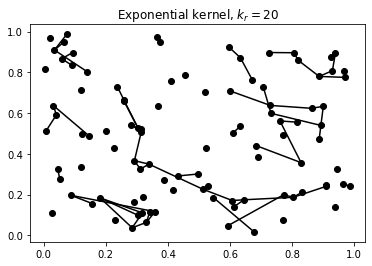

In [10]:
fig, ax = plt.subplots()
ax = plot_nodes(ax, pos_exp)
ax = plot_edges(ax, G_exp.edges, pos_exp)
ax.set_title(f'Exponential kernel, $k_r = {kr_exp}$');

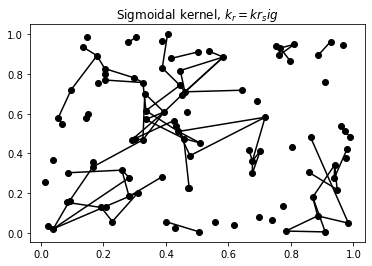

In [11]:
fig, ax = plt.subplots()
ax = plot_nodes(ax, pos_sig)
ax = plot_edges(ax, G_sig.edges, pos_sig)
ax.set_title('Sigmoidal kernel, $k_r = {kr_sig}$');

## Make inter-vertex distances

In [12]:
def make_inter_vertex_distances(pos):

    distance = np.zeros((n,n))

    for i in tqdm(range(n)):
        for j in range(n):
            distance[i,j] =np.sqrt(np.sum((np.array(pos[i]) - np.array([pos[j]]))**2))
    
    return distance

In [13]:
distance_exp = make_inter_vertex_distances(pos_exp)
distance_sig = make_inter_vertex_distances(pos_sig)

100%|██████████| 100/100 [00:00<00:00, 922.40it/s]


---

## Inference
Define the spatial Bernoulli graph as:

$$P(Y=y|D) = \prod_{i>j} B(Y_{ij} = y_{ij}| \mathcal{F}(D_{ij}, \theta))$$

where $Y$ is the random graph adjacency matrix, $D$ is a matrix of inter-vertex distances, $B$ is the Bernoulli pmf, and $F$ is a function taking distances into the $[0,1]$ interval. The log likelihood is

$$l = \sum_{i>j}[ y_{ij}\log(\mathcal{F}(D_{ij})) + (1-y_{ij})  \log(1 - \mathcal{F}(D_{ij})   ]$$

---

Let $\mathcal{F}(D_{ij}) = e^{-k_r D_{ij}}$ in the exponential case, or $\mathcal{F}(D_{ij}) = 1 /(1 + e^{-k_r D_{ij}})$ in the sigmoidal case

Source: https://docs.pymc.io/Advanced_usage_of_Theano_in_PyMC3.html

---

In [14]:
def get_upper_triangle(G, distances):
    row, col = np.triu_indices_from(distance_sig, k=1)
    distance_filter = distances[row, col]
    
    adj = adjacency_matrix(G)
    adj_filter = adj[row, col]
    
    adj_filter = np.array(adj_filter).ravel()
    
    return distance_filter, adj_filter

In [15]:
distances_sig_filter, adj_sig_filter = get_upper_triangle(G_sig, distance_sig)
distances_exp_filter, adj_exp_filter = get_upper_triangle(G_exp, distance_exp)

In [16]:
adj_sig_bool = adj_sig_filter.astype(bool)
adj_exp_bool = adj_exp_filter.astype(bool)

#### Exponential case

In [17]:
distances_exp_tt = theano.shared(distances_exp_filter)

In [18]:
with pm.Model() as model_exp:
    kr = pm.Uniform('kr', 0, 100)
    exponential = pm.math.exp(-kr * distances_exp_tt)
    pm.Bernoulli('obs', p=exponential, observed=adj_exp_bool)

In [19]:
map_estimate_exp = pm.find_MAP(model=model_exp)

/home/juvid/miniconda3/envs/kolgraph/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -304.4, ||grad|| = 137.71: 100%|██████████| 9/9 [00:00<00:00, 1614.23it/s]


In [20]:
with model_exp:
    # fit the model
    trace_exp = pm.sample(1000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [kr]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:01<00:00, 3967.38draws/s]
The acceptance probability does not match the target. It is 0.8847709059749028, but should be close to 0.8. Try to increase the number of tuning steps.


Text(0.5, 0, 'Samples')

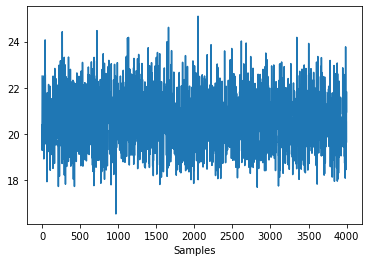

In [21]:
fig, ax = plt.subplots()
ax.plot(range(len(trace_exp['kr'])), trace_exp['kr'])
ax.set_xlabel('Iterations')
ax.set_xlabel('Samples')

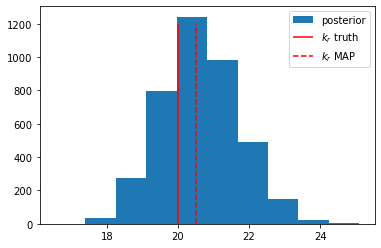

In [22]:
fig, ax = plt.subplots()
ax.hist(trace_exp['kr'], label='posterior')
ax.vlines(kr_exp, 0, 1200, color='red', label='$k_r$ truth')
ax.vlines(map_estimate_exp['kr'], 0, 1200, color='red', linestyle='--', label='$k_r$ MAP')
ax.legend();

#### Sigmoidal case

In [23]:
distances_sig_tt = theano.shared(distances_sig_filter)

In [24]:
with pm.Model() as model_sig:
    kr = pm.Uniform('kr', -100, 0)
    logistic = pm.math.sigmoid(kr * distances_sig_tt)
    pm.Bernoulli('obs', p=logistic, observed=adj_sig_bool)

In [25]:
map_estimate_sig = pm.find_MAP(model=model_sig)

/home/juvid/miniconda3/envs/kolgraph/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -508.76, ||grad|| = 237.15: 100%|██████████| 9/9 [00:00<00:00, 1540.76it/s]


In [26]:
with model_sig:
    # fit the model
    trace_sig = pm.sample(1000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [kr]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:02<00:00, 2254.53draws/s]
The acceptance probability does not match the target. It is 0.8793043453404533, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8850042798775197, but should be close to 0.8. Try to increase the number of tuning steps.


Text(0.5, 0, 'Samples')

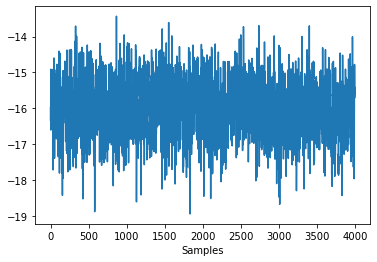

In [27]:
fig, ax = plt.subplots()
ax.plot(range(len(trace_sig['kr'])), trace_sig['kr'])
ax.set_xlabel('Iterations')
ax.set_xlabel('Samples')

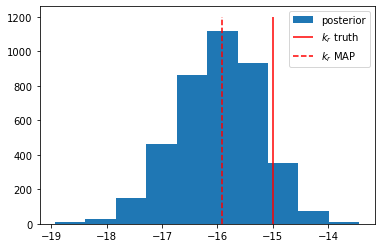

In [28]:
fig, ax = plt.subplots()
ax.hist(trace_sig['kr'], label='posterior')
ax.vlines(kr_sig, 0, 1200, color='red', label='$k_r$ truth')
ax.vlines(map_estimate_sig['kr'], 0, 1200, color='red', linestyle='--', label='$k_r$ MAP')
ax.legend();

---

## Other simple pymc3 examples

### Bernoulli with a sigmoidal probability

In [29]:
x = np.random.randn(100)
coeff_true = 2
p = 1/(1+np.exp(-coeff_true*x))
y = np.array([r.uniform() < pi  for pi in p])

In [30]:
x_shared = theano.shared(x)

with pm.Model() as model_dummy:
    coeff = pm.Normal('coeff', mu=0, sigma=2)
    #coeff = pm.Uniform('coeff', 0, 10)
    logistic = pm.math.sigmoid(coeff * x_shared)
    pm.Bernoulli('obs', p=logistic, observed=y)

In [31]:
map_estimate = pm.find_MAP(model=model_dummy)

/home/juvid/miniconda3/envs/kolgraph/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -70.927, ||grad|| = 34.822: 100%|██████████| 9/9 [00:00<00:00, 1847.35it/s]


In [32]:
map_estimate

{'coeff': array(1.93262721)}

In [33]:
with model_dummy:
    # fit the model
    trace = pm.sample()

    # Switch out the observations and use `sample_posterior_predictive` to predict
    x_shared.set_value([-1, 0, 1.])
    post_pred = pm.sample_posterior_predictive(trace, samples=500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [coeff]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:00<00:00, 7015.90draws/s]
The acceptance probability does not match the target. It is 0.8975193619513818, but should be close to 0.8. Try to increase the number of tuning steps.
100%|██████████| 500/500 [00:00<00:00, 899.94it/s]


### Custom likelihood for Bernoulli

Consider also:

https://github.com/pymc-devs/pymc3/issues/4057

In [34]:
import theano.tensor as tt
from scipy.stats import bernoulli
X = bernoulli.rvs(p=p, size=100)

In [35]:
nsample = 10000

In [36]:
with pm.Model() as bernoulli:
    theta = pm.Beta('p', alpha=0.5, beta=0.5)
    X_obs = pm.Bernoulli('X_obs', p=theta, observed=X)

with bernoulli:
    trace_pm = pm.sample(nsample)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6170.15draws/s]


In [37]:
def log_like_bernoulli(p, x):             
    return tt.log(p) * tt.sum(x) + tt.log(1-p) * tt.sum(1-x)

In [38]:
with pm.Model() as my_bernoulli:
    theta = pm.Beta('p', alpha=0.5, beta=0.5)    
    ll = pm.DensityDist('ll', log_like_bernoulli, observed=dict(p=theta, x=X))

In [39]:
with my_bernoulli:
    trace_custom = pm.sample(nsample)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6222.09draws/s]


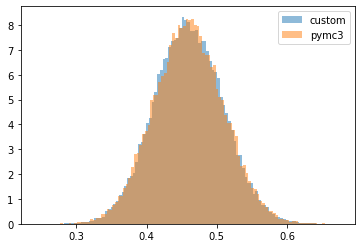

In [40]:
fig, ax = plt.subplots()
ax.hist(trace_custom['p'], label='custom', bins='auto', density=True, alpha=0.5)
ax.hist(trace_pm['p'], label='pymc3', bins='auto', density=True, alpha=0.5)
ax.legend()